# Alzheimer's Disease classification from anatomical MRI

### This notebook explores the use of a low-dimensional feature space to classify Alzheimer's disease from anatomical MRI images.

Briefly, the pipeline involves the following steps and technical features:

- Data formating and quality check
- Feature extraction and visualization
- Random forest classification as a function of features (principal components) used
- Permutation testing for statistical significance  (parallel processing)
- Feature interpretation

### Import analysis and plotting libraries

In [1]:
# "standard"
import numpy as np
import pandas as pd

# machine learning and statistics
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from scipy.stats import false_discovery_control

# Parallel computing
import dask
from dask.distributed import Client, progress

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

# misc
import cv2
import magic
from IPython.display import clear_output

### Load and format training data

In [2]:
BASE_DIR = "C:/Users/bedelman/Documents\GitHub/Alzheimers-MRI-Classification/Alzheimer_MRI_Dataset/Data/"

'''
Label meanings
0 - Mild dementia
1 - Moderate dementia
2 - No dementia
3 - Very mild dementia
'''
Lab = ['Mild', 'Moderate', 'None', 'Very Mild']

train = pd.read_parquet(f"{BASE_DIR}/train-00000-of-00001-c08a401c53fe5312.parquet", engine="pyarrow")
train.head()

,image,label
0,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,2
1,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,0
2,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,3
3,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,3
4,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,2


#### Convert data to readable format

In [3]:
def dict_to_image(image_dict):
    if isinstance(image_dict, dict) and 'bytes' in image_dict:
        byte_string = image_dict['bytes']
        nparr = np.frombuffer(byte_string, np.uint8)
        img = cv2.imdecode(nparr, cv2.IMREAD_GRAYSCALE)
        return img
    else:
        raise TypeError(f"Expected dictionary with 'bytes' key, got {type(image_dict)}")

train['img_arr'] = train['image'].apply(dict_to_image)
train.drop("image", axis=1, inplace=True)
train.head()

,label,img_arr
0,2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
1,0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
2,3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
3,3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
4,2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."


### Load and format test data

In [4]:
test = pd.read_parquet(f"{BASE_DIR}/test-00000-of-00001-44110b9df98c5585.parquet", engine="pyarrow")
test.head() 

# Also convert to readable format
test['img_arr'] = test['image'].apply(dict_to_image)
test.drop("image", axis=1, inplace=True)
test.head()

,label,img_arr
0,3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
1,0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
2,2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
3,3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
4,0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."


## Explore structure and visualization of the data

### Distribution of the datasets (are all classes represented equally?)

Text(0, 0.5, '# of images')

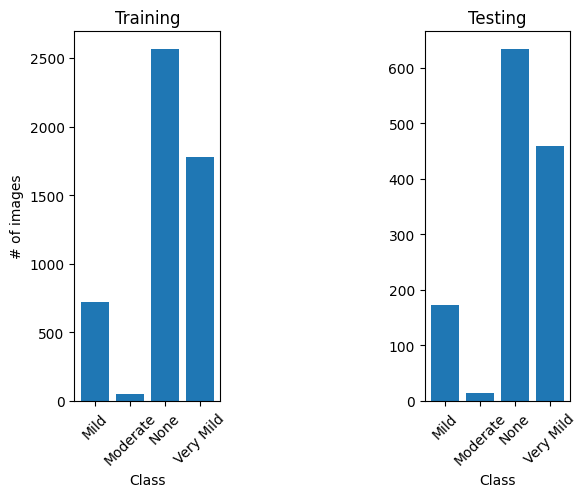

In [7]:
f, ax = plt.subplots(1,3)
unique, counts = np.unique(np.asarray(train.iloc[:].label), return_counts = True)
ax[0].bar(unique, counts)
ax[0].set_xticks(unique)
ax[0].set_xticklabels(Lab, rotation = 45)
ax[0].set_title('Training')
ax[0].set_xlabel('Class')
ax[0].set_ylabel('# of images')

ax[1].axis('off')

unique, counts = np.unique(np.asarray(test.iloc[:].label), return_counts = True)
ax[2].bar(unique, counts)
ax[2].set_xticks(unique)
ax[2].set_xticklabels(Lab, rotation = 45)
ax[2].set_title('Testing')
ax[2].set_xlabel('Class')
ax[0].set_ylabel('# of images')

# An obvious imbalance across classes, but each class seems to be balanced across training/testing sets

## Visually inspect data

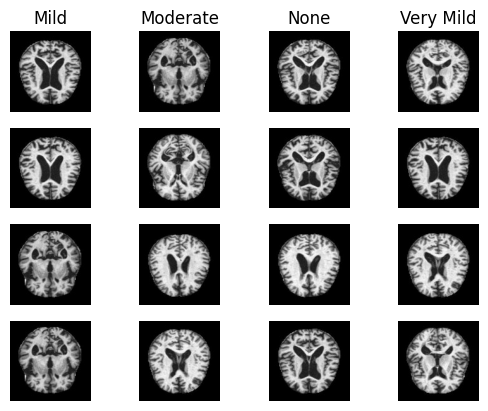

In [11]:
train_lab_idx = np.asarray(train.iloc[:].label)

f, ax = plt.subplots(4,4)
for lab in range(4):
    for ex in range(4):
    
        class_lab = np.argwhere(train_lab_idx == 1)
        current_idx = np.random.randint(len(class_lab)-1,size = 1)
        current_idx = np.asarray(current_idx)
        
        ax[ex, lab].axis('off')
        ax[ex, lab].imshow(train.iloc[class_lab[current_idx[0]][0]].img_arr, cmap = "gray")
        if ex == 0: ax[ex, lab].set_title(Lab[lab])

# Clearly, images show different slices within the brain, which may be a major confound...

## Feature engineering for visualization and classification

- Raw pixel intensity X PCA
- Histogram of oriented gradients
- Segmented brain volume


### PCA on raw pixel data

Text(0, 0.5, 'Variance Explained')

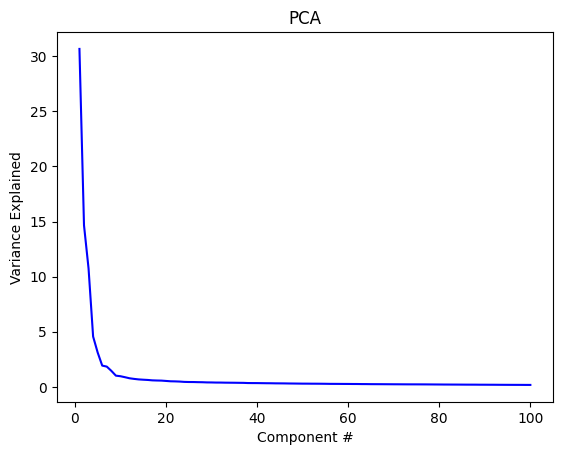

In [13]:
train_data = []
for i in range(len(train)):
    train_data.append(np.reshape(train.iloc[i].img_arr, (1, -1)))    
train_data = np.vstack(train_data[:])

# decompose with PCA and look at various metrics/info
pca = PCA(n_components = 100)
pca.fit(train_data)

plt.plot(np.linspace(1,100,100),pca.explained_variance_[:100]/sum(pca.explained_variance_[:100])*100,'b')
plt.title('PCA')
plt.xlabel('Component #')
plt.ylabel('Variance Explained')

### Project training data into PCA space to visualize potential clustering

#### First, use first two PC's for simple visualization

Text(0, 0.5, 'PC 2')

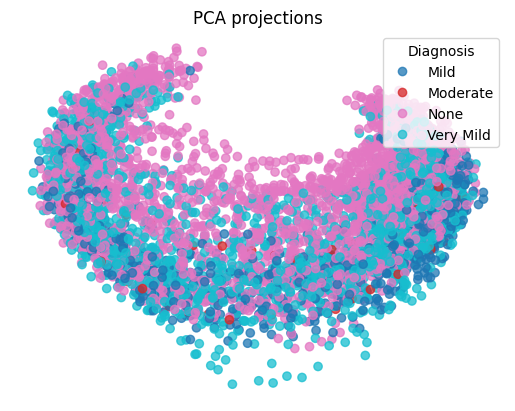

In [14]:
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
load_train = np.matmul(train_data, loadings[:,:2])

# plot first two PCs
s  = plt.scatter(load_train[:,0], load_train[:,1], c = train_lab_idx*2, cmap = 'tab10', alpha = 0.75)
handles, labels = s.legend_elements()
legend = plt.legend(handles = handles, labels = Lab, title = 'Diagnosis', loc = 'upper right')
plt.axis('off')
plt.title('PCA projections')
plt.xlabel('PC 1')
plt.ylabel('PC 2')


## Apply random forest classifier to first two PCs

In [15]:
# Train random forest classifier and apply to test data
## for now again only with first two PCs

rf_1 = RandomForestClassifier()

# Train classifier
load_train = np.matmul(train_data, loadings[:,:2])
rf_1.fit(load_train, train_lab_idx)

# Properly format test data and extract same features (PC loadings)
test_data = []
for i in range(len(test)):
    test_data.append(np.reshape(test.iloc[i].img_arr, (1, -1)))    
test_data = np.vstack(test_data[:])

load_test = np.matmul(test_data, loadings[:,:2])

# Predict unseen data
predictions_1 = rf_1.predict(load_test)
test_lab_idx = np.asarray(test.iloc[:].label)

# compare predictions with test labels and compute accuracy
result = predictions_1 - test_lab_idx
result_binary = np.argwhere(result == 0)
correct = np.size(result_binary,0)
acc = correct/test_lab_idx.shape[0]*100
print(acc)

# When using the top two PCs, we see a modest classification rate on the test set. 
## However, using two PC's here is arbitrary due to easy visualization purposes.
## We can also exmaine accuracy as a function of the number of PCs and visualize the PC loading maps to interpret the classification results

48.671875


## Permutation testing on shuffled data as a control

### Parallelize time-consuming iterative processes with Dask (local)

In [19]:
client = Client(threads_per_worker = 4, n_workers = 1)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 1
Total threads: 4,Total memory: 15.59 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:55953,Workers: 1
Dashboard: http://127.0.0.1:8787/status,Total threads: 4
Started: Just now,Total memory: 15.59 GiB
Comm: tcp://127.0.0.1:55960,Total threads: 4
Dashboard: http://127.0.0.1:55961/status,Memory: 15.59 GiB
Nanny: tcp://127.0.0.1:55956,


### Shuffle data labels in the training set when building RF classifier

#### Do this a number of times to generate a null distribution

In [21]:
test_lab_idx = np.asarray(test.iloc[:].label)
train_lab_idx_shuffle = train_lab_idx
load_train = np.matmul(train_data, loadings[:,:2])

rng = np.random.default_rng()

def classification_RF_shuffle(load_train, train_lab_idx_shuffle, load_test, test_lab_idx):
    
    # Train classifier with new shuffled labels each iteration
    rf_1 = RandomForestClassifier()
    rng.shuffle(train_lab_idx_shuffle)
    rf_1.fit(load_train, train_lab_idx_shuffle)

    # Predict unseen data
    predictions_1 = rf_1.predict(load_test)
    test_lab_idx = np.asarray(test.iloc[:].label)

    # compare predictions with test labels and compute accuracy
    result = predictions_1 - test_lab_idx
    result_binary = np.argwhere(result == 0)
    correct = np.size(result_binary,0)
    acc = correct/test_lab_idx.shape[0]*100
    return acc

# Parallelize lazy function to reduce computation time
## limit number of iterations in this function to account for computer memory limit
def iteration_permute(load_train, train_lab_idx_shuffle, load_test, test_lab_idx):
    
    acc_shuffle = []
    for i in range(100):
        acc_tmp = dask.delayed(classification_RF_shuffle)(load_train, train_lab_idx_shuffle, load_test, test_lab_idx)
        acc_shuffle.append(acc_tmp)
    
    # compute values
    acc_shuffle = dask.compute(*acc_shuffle)
    acc_shuffle = np.array([float(num) for num in acc_shuffle])
    clear_output(wait = True)
    return acc_shuffle

## Permute a sufficient number of times (here 500)

### Not the most efficient way to do this, but must consider memory on local machine

CPU times: total: 1min 11s
Wall time: 4min 47s


(30.0, 60.0)

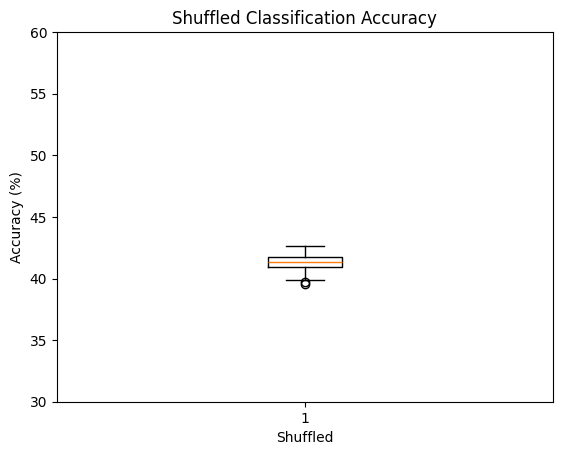

In [97]:
%%time

acc_shuffle_compile = []
for i in range(5):
    acc_tmp = iteration_permute(load_train, train_lab_idx_shuffle, load_test, test_lab_idx)
    acc_shuffle_compile = np.concatenate((acc_shuffle_compile, acc_tmp), axis=0)

b = plt.boxplot(acc_shuffle_compile)
plt.title('Shuffled Classification Accuracy')
plt.xlabel('Shuffled')
plt.ylabel('Accuracy (%)')
plt.ylim(30, 60)

## Side note: validate parallel processing by comparing computation against serial processing

In [100]:
%%time

# simple test to ensure that parallel processing is faster

# traditional for loop
acc_shuffle_nodask = []
for i in range(100):
    acc_tmp = classification_RF_shuffle(load_train, train_lab_idx, load_test, test_lab_idx)
    acc_shuffle_nodask.append(acc_tmp)

CPU times: total: 2min 43s
Wall time: 2min 43s


In [101]:
%%time

# dask parallelization
acc_shuffle_dask = []
for i in range(1):
    acc_tmp = iteration_permute(load_train, train_lab_idx_shuffle, load_test, test_lab_idx)
    acc_shuffle_dask = np.concatenate((acc_shuffle_dask, acc_tmp), axis=0)
    clear_output(wait = True)

CPU times: total: 13.5 s
Wall time: 56.5 s


## Determine significance of classification accuracy (permutation test)

In [131]:
null_above_value = (acc_shuffle_compile > acc).sum()
p_value = null_above_value/np.size(acc_shuffle_compile,0)
print(p_value)

# We can see here that the classification accuracy is not sigificcantly different from chance with p-value > 0.05

0.0


## Now explore RF classification as a function of PCs

In [23]:
def classification_RF_PCs(train_data, train_lab_idx, test_data, test_lab_idx, loadings, num_pc):

    load_train = np.matmul(train_data, loadings[:,:num_pc])
    
    rf_1 = RandomForestClassifier()
    rf_1.fit(load_train, train_lab_idx)
    
    load_test = np.matmul(test_data, loadings[:,:num_pc])
    
    # Predict unseen data
    predictions_1 = rf_1.predict(load_test)
    test_lab_idx = np.asarray(test.iloc[:].label)
    
    # compare predictions with test labels and compute accuracy
    result = predictions_1 - test_lab_idx
    result_binary = np.argwhere(result == 0)
    correct = np.size(result_binary,0)
    acc = correct/test_lab_idx.shape[0]*100
    return acc

def iteration_PCs(train_data, train_lab_idx, test_data, test_lab_idx, loadings, pc_idx):
    
    acc_PC = []
    for i in pc_idx:
        acc_tmp = dask.delayed(classification_RF_PCs)(train_data, train_lab_idx, test_data, test_lab_idx, loadings, i)
        acc_PC.append(acc_tmp)
    
    # compute values
    acc_PC = dask.compute(*acc_PC)
    clear_output(wait = True)
    acc_PC = np.array([float(num) for num in acc_PC])
    return acc_PC

### Batch parallel processing to conserve memory

CPU times: total: 18.9 s
Wall time: 3min 29s


(30.0, 100.0)

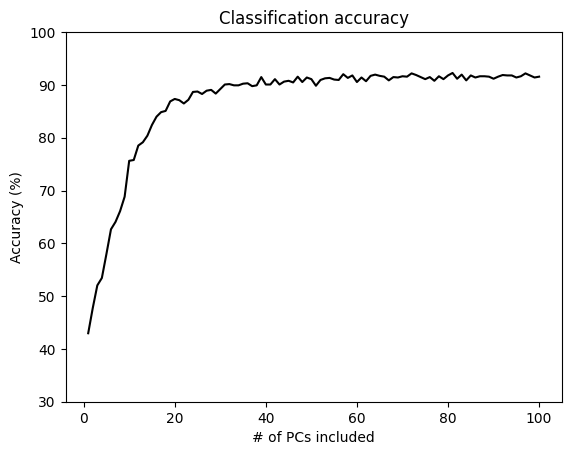

In [25]:
%%time

idx = [np.linspace(1,50,50, dtype = 'int'), np.linspace(51,100,50, dtype = 'int')]

acc_PC_compile = []
for i in range(len(idx)):
    
    acc_tmp = iteration_PCs(train_data, train_lab_idx, test_data, test_lab_idx, loadings, idx[i])
    acc_PC_compile = np.concatenate((acc_PC_compile, acc_tmp), axis = 0)

# plot accuracy as a function of PCs
plt.plot(np.linspace(1,np.size(acc_PC_compile,0), np.size(acc_PC_compile,0)), acc_PC_compile, 'k')
plt.title('Classification accuracy')
plt.xlabel('# of PCs included')
plt.ylabel('Accuracy (%)')
plt.ylim(30, 100)
plt.xlim(-5, 105)

## Permutation testing for each number of PCs

In [27]:
def classification_RF_shuffle_PCs(train_data, train_lab_idx_shuffle, test_data, test_lab_idx, loadings, num_pc):

    load_train = np.matmul(train_data, loadings[:,:num_pc])
    
    rf_1 = RandomForestClassifier()
    rng.shuffle(train_lab_idx_shuffle)
    rf_1.fit(load_train, train_lab_idx_shuffle)
    
    load_test = np.matmul(test_data, loadings[:,:num_pc])
    
    # Predict unseen data
    predictions_1 = rf_1.predict(load_test)
    test_lab_idx = np.asarray(test.iloc[:].label)
    
    # compare predictions with test labels and compute accuracy
    result = predictions_1 - test_lab_idx
    result_binary = np.argwhere(result == 0)
    correct = np.size(result_binary,0)
    acc = correct/test_lab_idx.shape[0]*100
    return acc

def iteration_permute_PCs(train_data, train_lab_idx_shuffle, test_data, test_lab_idx, loadings, num_pc):
    
    acc_shuffle = []
    for i in range(100):
        acc_tmp = dask.delayed(classification_RF_shuffle_PCs)(train_data, train_lab_idx_shuffle, test_data, test_lab_idx, loadings, num_pc)
        acc_shuffle.append(acc_tmp)
    
    # compute values
    acc_shuffle = dask.compute(*acc_shuffle)
    acc_shuffle = np.array([float(num) for num in acc_shuffle])
    clear_output(wait = True)
    return acc_shuffle

# def iteration_shuffle_PCs(train_data, train_lab_idx, test_data, test_lab_idx, loadings, pc_idx):
    
#     acc_PC = []
#     for i in pc_idx:
#         acc_tmp = dask.delayed(iteration_permute_PCs)(train_data, train_lab_idx_shuffle, test_data, test_lab_idx, loadings, i)
#         acc_PC.append(acc_tmp)
    
#     # compute values
#     acc_PC = dask.compute(*acc_PC)
#     clear_output(wait = True)
#     # acc_PC = np.array([float(num) for num in acc_PC])
#     return acc_PC

In [ ]:
%%time

idx = np.linspace(1,100,100, dtype = 'int')
acc_shuffle_PC_compile = []
for i in idx:
    acc_tmp = iteration_permute_PCs(train_data, train_lab_idx_shuffle, test_data, test_lab_idx, loadings, i)
    acc_shuffle_PC_compile.append(acc_tmp)


C:\Users\bedelman\Desktop\PySpark_proj\my_venv\lib\site-packages\distributed\client.py:3371: UserWarning: Sending large graph of size 132.61 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


## Compare classification accuracy to chance level for each number of PCs

array([0., 0., 0., 0., 0.])

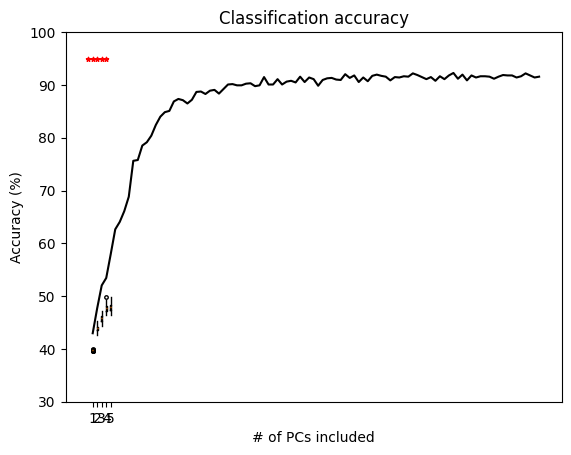

In [101]:
# plot accuracy as a function of PCs

# accuracy as a function of PCs
plt.plot(np.linspace(1,np.size(acc_PC_compile,0), np.size(acc_PC_compile,0)), acc_PC_compile, 'k')

# corresponding chance level
p_value_compile = []
for i in range(len(acc_shuffle_PC_compile)):
    b = plt.boxplot(acc_shuffle_PC_compile[i], positions = [i+1], flierprops = {'marker': '.', 'markersize': 5})

    # permutation testing
    null_above_value = (acc_shuffle_PC_compile[i] > acc_PC_compile[i]).sum()
    p_value_compile.append(null_above_value/np.size(acc_shuffle_PC_compile[i],0))

# visualize statistical results
p_value_compile = np.array([float(num) for num in p_value_compile])
p_value_adj = false_discovery_control(p_value_compile)   

for i in range(len(p_value_adj)): 
    if p_value_adj[i] < 0.05:
        plt.scatter(i, 95, s = 10, c = 'r', marker = "*")

plt.title('Classification accuracy')
plt.xlabel('# of PCs included')
plt.ylabel('Accuracy (%)')
plt.ylim(30, 100)
plt.xlim(-5, 105)
p_value_compile

## Feature interpretation

### Visualize spatial PC maps to identify features that contribute to data variance and classification

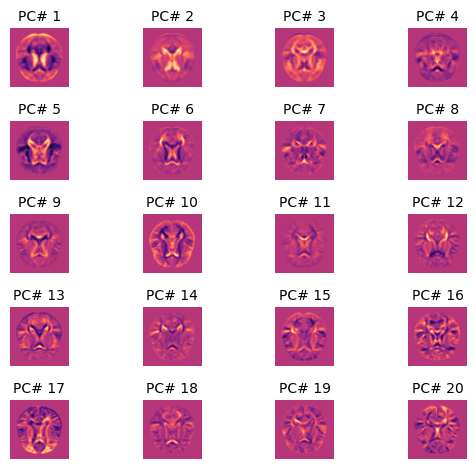

In [143]:
f, ax = plt.subplots(5,4)
lim = 20
for ipc in range(lim):

    PC_map = loadings[:,ipc]
    PC_map = np.reshape(PC_map, (128,128))
    clim = max(abs(np.min(PC_map)), abs(np.max(PC_map)))

    idx1 = np.floor(ipc/4).astype(int)
    idx2 = np.fmod(ipc,4)
    ax[idx1, idx2].axis('off')
    ax[idx1, idx2].imshow(PC_map, cmap = "magma", vmin = -clim, vmax = clim)
    ax[idx1, idx2].set_title(f'PC# {ipc +1}', fontsize = 10)
    plt.tight_layout()

##### Here we can see that for each of the top 20 PC's there are brain regions are more strongly weighted than others (in either the positive or negative direction). It is important to note that it does not appear that each image used in this dataset came from the same location/slice within the brain. We do not know if certain slices are over- or under-represented in different AD classes and therefore cannot say with certainty whether specific anatomical structures drive different stages of AD. Nevertheless,